# Explainability Methods

Machine learning models, especially those dealing with time series data, often operate as complex **black boxes**, making it challenging to interpret their decisions. Explainability methods play a crucial role in demystifying these models and enhancing their trustworthiness.

In this notebook, we'll explore key explainability techniques, implemented in out framework, including SHAP, and Time Series Points Perturbation Analysis.

Before we start with explainability methods, let's train two models: a simple statistical model and a complex one with several preprocessing nodes:

In [11]:
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.core.optimizer.IndustrialEvoOptimizer import IndustrialEvoOptimizer
from fedot_ind.api.main import FedotIndustrial as FI
from fedot_ind.tools.explain.explain import PointExplainer

ml_task = 'classification'
fourier_model = PipelineBuilder().add_node('quantile_extractor').add_node('rf')
eigen_model = PipelineBuilder().add_node('eigen_basis').add_node('quantile_extractor').add_node('rf')
topo_model = PipelineBuilder().add_node('topological_extractor').add_node('rf')
available_operations = {'stat_basis': fourier_model,
                         'eigen_basis':eigen_model,
                         'topo_basis':topo_model}
model_dict = {}
for model_name, model_impl in available_operations.items():
    experiment_setup = {'problem': ml_task,
                        'metric': 'accuracy',
                        'timeout': 5,
                        'num_of_generations': 5,
                        'pop_size': 10,
                        'logging_level': 40,
                        'available_operations':model_impl,
                        'n_jobs': 4,
                        'industrial_preprocessing': True,
                        'initial_assumption': None,
                        'max_pipeline_fit_time': 5,
                        'with_tuning': False,
                        'early_stopping_iterations': 5,
                        'early_stopping_timeout': 10,
                        'optimizer': IndustrialEvoOptimizer}
    automl_model = FI(**experiment_setup)
    model_dict.update({model_name:automl_model})

## Synthetic data

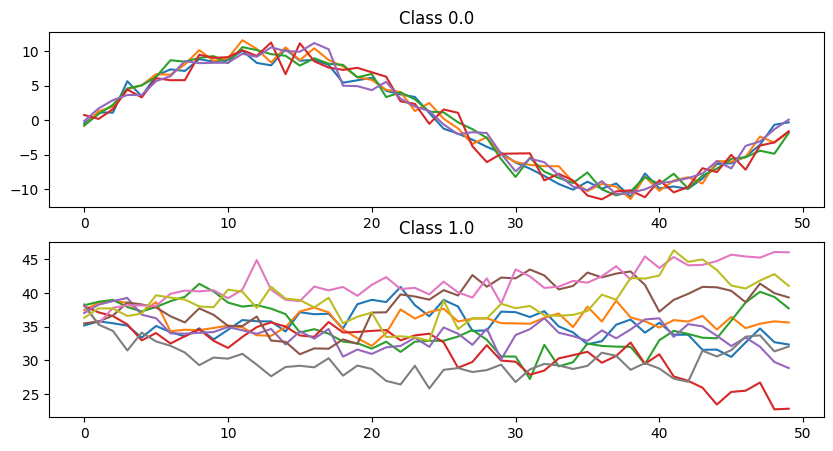

In [13]:
from fedot_ind.tools.synthetic.ts_datasets_generator import TimeSeriesDatasetsGenerator
import matplotlib.pyplot as plt
import numpy as np


generator = TimeSeriesDatasetsGenerator(num_samples=14,
                                        max_ts_len=50,
                                        binary=True)
train_data, test_data = generator.generate_data()
X_test, y_test = test_data
X_train, y_train = train_data

class_1 = np.unique(y_train)[0]
class_2 = np.unique(y_train)[1]
class_1_idx = np.where(y_train == class_1)[0]
class_2_idx = np.where(y_train == class_2)[0]
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(X_train.iloc[class_1_idx, :].T)
axs[0].set_title(f'Class {class_1}')
axs[1].plot(X_train.iloc[class_2_idx, :].T)
axs[1].set_title(f'Class {class_2}')
plt.show()

In [14]:
stat_model = model_dict['stat_basis']
stat_model.fit(input_data=train_data)
stat_labels = stat_model.predict(predict_data=test_data)
stat_probs = stat_model.predict_proba(predict_data=test_data)

100%|██████████| 14/14 [00:00<00:00, 1754.78it/s]


In [6]:
metric_df = stat_model.get_metrics(y_test,stat_labels)
metric_df

,0
accuracy:,1.0
f1,1.0
roc_auc:,1.0


100%|██████████| 10/10 [00:00<00:00, 10027.02it/s]

100%|██████████| 10/10 [00:00<00:00, 4954.29it/s]

100%|██████████| 10/10 [00:00<00:00, 10019.84it/s]

100%|██████████| 10/10 [00:00<00:00, 10275.12it/s]

100%|██████████| 10/10 [00:00<00:00, 10024.63it/s]

100%|██████████| 10/10 [00:00<00:00, 10012.66it/s]

100%|██████████| 10/10 [00:00<?, ?it/s][A

Processing points: 100%|██████████| 10/10 [00:00<00:00, 32.02point/s]


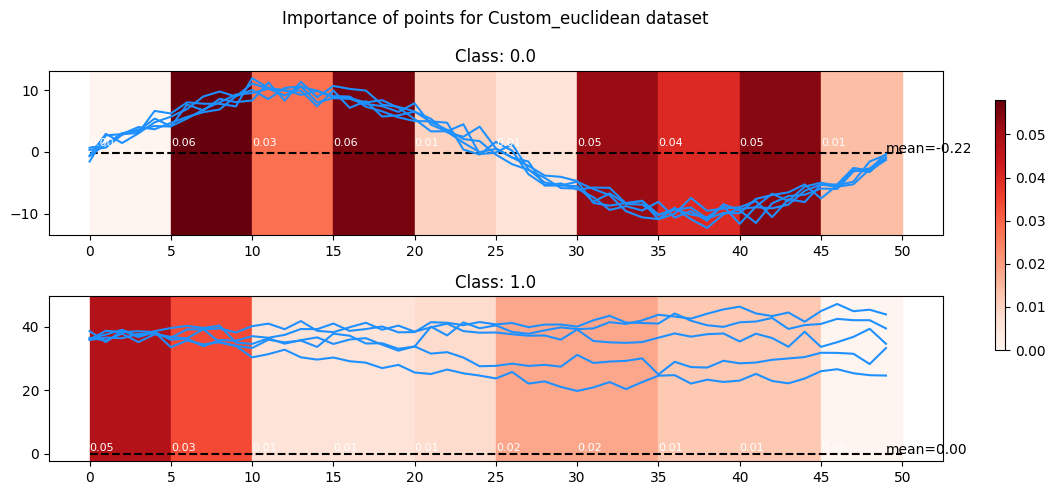

In [7]:
distance = 'euclidean'
explainer = PointExplainer(stat_model, X_test, y_test)
explainer.explain(n_samples=5, window=10, method=distance)
explainer.visual(threshold=0, name='Custom'+'_'+distance)

In [9]:
eigen_model = model_dict['eigen_basis']
eigen_model.fit(input_data=train_data)
eigen_labels = eigen_model.predict(predict_data=test_data)
eigen_probs = eigen_model.predict_proba(predict_data=test_data)

2024-01-19 18:28:46,686 - Initialising Industrial Repository


100%|██████████| 14/14 [00:00<00:00, 936.42it/s]


In [10]:
metric_df = eigen_model.get_metrics(y_test,eigen_labels)
metric_df

,0
accuracy:,1.0
f1,1.0
roc_auc:,1.0


In [5]:
topo_model = model_dict['topo_basis']
topo_model.fit(input_data=train_data)
topo_labels = topo_model.predict(predict_data=test_data)
topo_probs = topo_model.predict_proba(predict_data=test_data)

2024-01-19 18:28:13,877 - Initialising Industrial Repository


100%|██████████| 14/14 [00:00<00:00, 111.41it/s]


In [7]:
metric_df = topo_model.get_metrics(y_test,topo_labels)
metric_df

,0
accuracy:,0.357143
f1,0.307692
roc_auc:,0.366667


## Real data

In [15]:
from fedot_ind.tools.loader import DataLoader
dataset = 'Beef'
train_data_beef, test_data_beef = DataLoader(dataset).load_data()

In [16]:
available_operations = {'stat_basis': fourier_model,
                         'eigen_basis':eigen_model,
                         'topo_basis':topo_model}
model_dict = {}
for model_name, model_impl in available_operations.items():
    experiment_setup = {'problem': ml_task,
                        'metric': 'accuracy',
                        'timeout': 5,
                        'num_of_generations': 5,
                        'pop_size': 10,
                        'logging_level': 40,
                        'available_operations':model_impl,
                        'n_jobs': 4,
                        'industrial_preprocessing': True,
                        'initial_assumption': None,
                        'max_pipeline_fit_time': 5,
                        'with_tuning': False,
                        'early_stopping_iterations': 5,
                        'early_stopping_timeout': 10,
                        'optimizer': IndustrialEvoOptimizer}
    automl_model = FI(**experiment_setup)
    model_dict.update({model_name:automl_model})
stat_model_beef = model_dict['stat_basis']
stat_model_beef.fit(train_data_beef)
stat_labels_beef = stat_model_beef.predict(test_data_beef)
stat_probs_beef = stat_model_beef.predict_proba(train_data_beef)

100%|██████████| 30/30 [00:00<00:00, 589.81it/s]


In [4]:
metric_df_stat_beef = stat_model_beef.get_metrics(train_data_beef[1],stat_labels_beef,stat_probs_beef)
metric_df_stat_beef

,0
accuracy:,0.533333
f1,0.515556
roc_auc:,1.000000


Processing points: 100%|██████████| 10/10 [00:01<00:00,  6.98point/s]


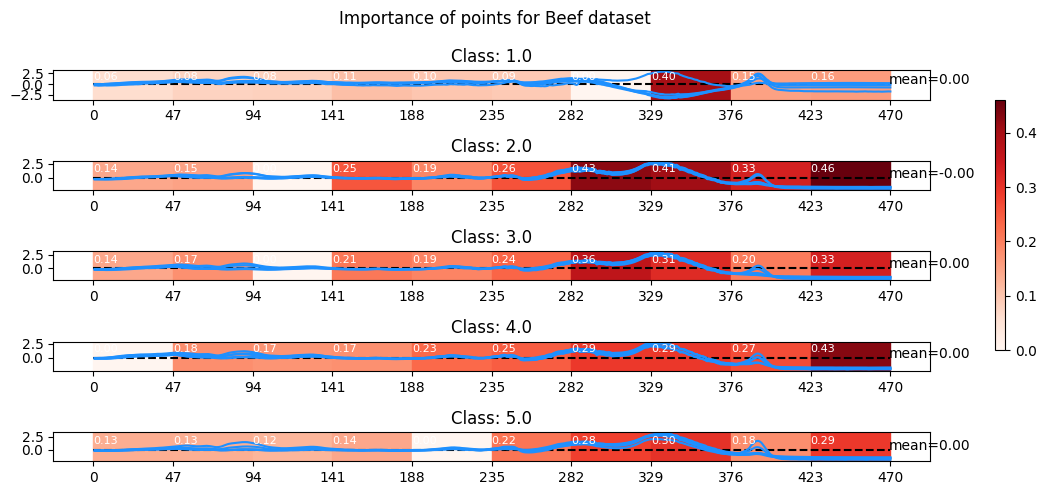

In [5]:
distance = 'euclidean'
explainer = PointExplainer(stat_model_beef,test_data_beef[0],test_data_beef[1])
explainer.explain(n_samples=5, window=10, method=distance)
explainer.visual(threshold=0, name='Beef')

In [7]:
eigen_model_beef = model_dict['eigen_basis']
eigen_model_beef.fit(input_data=train_data_beef)
eigen_labels_beef = eigen_model_beef.predict(predict_data=test_data_beef)
eigen_probs_beef = eigen_model_beef.predict_proba(predict_data=test_data_beef)

2024-01-22 13:16:51,301 - Initialising Industrial Repository


100%|██████████| 30/30 [00:00<00:00, 164.37it/s]


In [8]:
metric_df_eigen_beef = eigen_model_beef.get_metrics(train_data_beef[1],eigen_labels_beef,eigen_probs_beef)
metric_df_eigen_beef

,0
accuracy:,0.766667
f1,0.768825
roc_auc:,0.914000


Processing points: 100%|██████████| 10/10 [00:05<00:00,  1.88point/s]


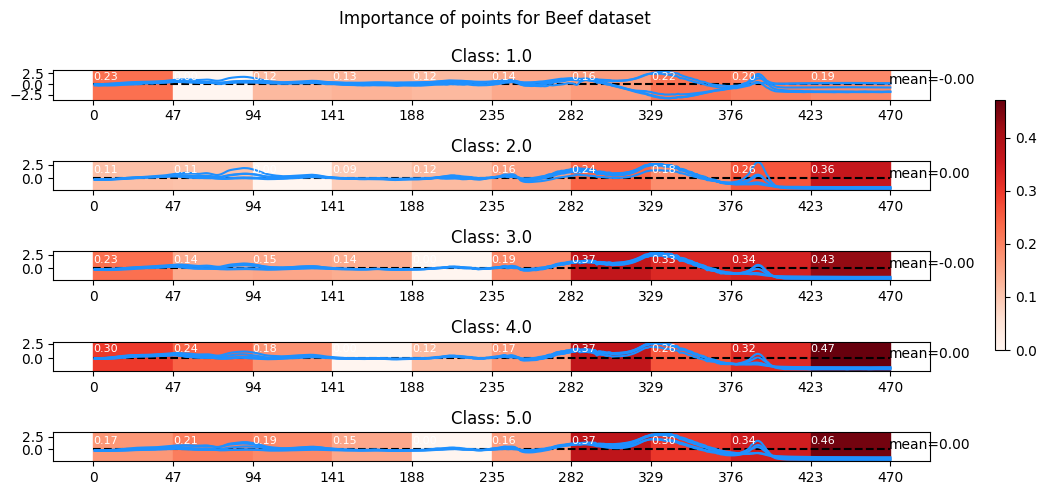

In [9]:
distance = 'euclidean'
explainer = PointExplainer(eigen_model_beef,test_data_beef[0],test_data_beef[1])
explainer.explain(n_samples=5, window=10, method=distance)
explainer.visual(threshold=0, name='Beef')

In [ ]:
dataset = 'Car'
train_data_car, test_data_car = DataLoader(dataset).load_data()

In [23]:
from fedot_ind.core.repository.model_repository import default_industrial_availiable_operation
experiment_setup = {'problem': ml_task,
                        'metric': 'accuracy',
                        'timeout': 5,
                        'num_of_generations': 5,
                        'pop_size': 10,
                        'logging_level': 40,
                        'available_operations':default_industrial_availiable_operation(ml_task),
                        'n_jobs': 4,
                        'initial_assumption': None,
                        'max_pipeline_fit_time': 5,
                        'with_tuning': False,
                        'early_stopping_iterations': 5,
                        'early_stopping_timeout': 10,
                        'optimizer': IndustrialEvoOptimizer}
automl_model = FI(**experiment_setup)

In [24]:
automl_model.fit(input_data=train_data_beef)
automl_model_labels = automl_model.predict(predict_data=test_data_beef)
automl_model_probs = automl_model.predict_proba(predict_data=test_data_beef)

Creating Dask Server
2024-01-22 13:44:28,318 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.4 MiB, max: 1.0 MiB
2024-01-22 13:44:28,319 - ApiComposer - Initial pipeline was fitted in 0.6 sec.
2024-01-22 13:44:28,320 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2024-01-22 13:44:28,329 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 5 min. Set of candidate models: ['xgboost', 'logit', 'knn', 'dt', 'rf', 'mlp', 'inception_model', 'omniscale_model', 'resnet_model', 'eigen_basis', 'wavelet_basis', 'fourier_basis', 'topological_extractor', 'quantile_extractor', 'signal_extractor', 'recurrence_extractor', 'minirocket_extractor', 'scaling', 'normalization', 'simple_imputation', 'kernel_pca', 'topological_features'].
2024-01-22 13:44:28,357 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 0/5 [00:00<?, ?gen/s]

2024-01-22 13:44:31,994 - IndustrialDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.


Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022D169E05E0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2392675469520
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022D169D88B0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2392675059536

SVD estimation: 100%|██████████| 24/24 [00:00<00:00, 276.68it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022D16A2A1F0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2392676141072

SVD estimation:

2024-01-22 13:45:23,877 - IndustrialDispatcher - 12 individuals out of 13 in previous population were evaluated successfully.


Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022D0F5DC790>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2392554471664
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022D058385E0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2392554505296
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022D1ED37700>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2392680738320


Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for validation
Epoch: 1, Training Loss: 3.57
Updating learning rate to 4.5571019283953884e-05
Epoch: 2, Training Loss: 3.52
Updating learning rate to 6.215475940305631e-05
Epoch: 3, Training Loss: 3.47
Updating learning rate to 8.936626895729232e-05
Epoch: 4, Training Loss: 3.39
Updating learning rate to 0.0001265738985946948
Epoch: 5, Training Loss: 3.35
Updating learning rate to 0.00017291396322267948
Epoch: 6, Training Loss: 3.25
Updating learning rate to 0.00022731079036765413
Epoch: 7, Training Loss: 3.15
Updating learning rate to 0.0002885016893087411
Epoch: 8, Training Loss: 3.07
Updating learning rate to 0.0003550662613875939
Epoch: 9, Training Loss: 2.91
Updating learning rate to 0.00042545937112638114
Epoch: 10, Training Loss: 2.82
Updating learning rate to 0.0004980470128092187
Epoch: 11, Training Loss: 2.67
Updating learning rate to 0.0005711442399711407
Epoch: 12, Training Loss: 2.56
Updating l

Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022D16B94670>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2392677970544
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022B9CFEA820>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2392389777328
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022B9CFEA160>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2392219523952
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy

2024-01-22 13:48:11,921 - IndustrialDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.
2024-01-22 13:48:12,695 - DataOperation - Can not find evaluation strategy because of Impossible to obtain <class 'fedot_ind.core.operation.interfaces.industrial_preprocessing_strategy.IndustrialClassificationPreprocessingStrategy'> strategy for topological_features


Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022D1EF411F0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2392815682640
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022D1F11E5E0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2392814307632
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022D249ACCA0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2386340598384
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy

2024-01-22 13:49:05,017 - IndustrialDispatcher - 6 individuals out of 7 in previous population were evaluated successfully.



100%|██████████| 24/24 [00:00<00:00, 153.32it/s]

100%|██████████| 6/6 [00:00<00:00, 3065.26it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022D1EC4E940>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2392817045744

100%|██████████| 24/24 [00:00<00:00, 157.28it/s]

100%|██████████| 6/6 [00:00<00:00, 3016.40it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022D1707C820>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2388001742736
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000022D058BB160>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv

2024-01-22 13:49:29,259 - IndustrialDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:  20%|██        | 1/5 [05:00<20:03, 300.91s/gen]

2024-01-22 13:49:29,328 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:  20%|██        | 1/5 [05:00<20:03, 300.97s/gen]


2024-01-22 13:49:29,544 - ApiComposer - Model generation finished
2024-01-22 13:49:29,627 - FEDOT logger - Final pipeline was fitted
2024-01-22 13:49:29,629 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [logit]}
logit - {}
2024-01-22 13:49:29,630 - MemoryAnalytics - Memory consumption for finish in main session: current 42.2 MiB, max: 63.5 MiB


In [25]:
metric_df_automl_beef = automl_model.get_metrics(train_data_beef[1],automl_model_labels,automl_model_probs)
metric_df_automl_beef

,0
accuracy:,0.800000
f1,0.797396
roc_auc:,0.933000


Processing points: 100%|██████████| 10/10 [00:00<00:00, 455.77point/s]


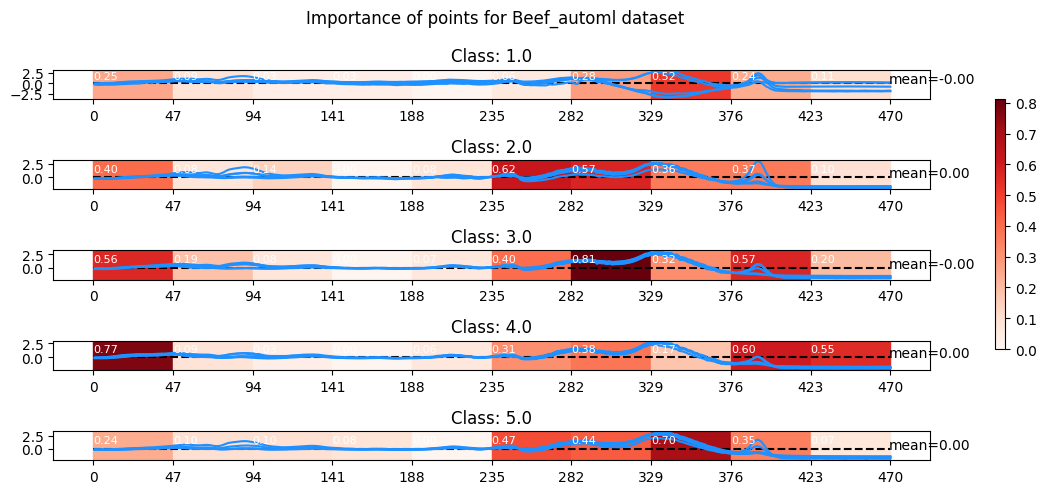

In [26]:
explainer_auto_car = PointExplainer(automl_model, test_data_beef[0], test_data_beef[1])
explainer_auto_car.explain(n_samples=5, window=10, method='euclidean')
explainer_auto_car.visual(threshold=0, name='Beef'+'_'+'automl')

## SHAP (SHapley Additive exPlanations)

SHAP values offer a game-theoretic approach to assign a value to each feature's contribution to a model's prediction.
In the context of time series, SHAP values can be calculated for individual time points or across the entire sequence. The formula for calculating SHAP values is given by:

$$\phi_i(f) = \sum_{S \subseteq N \setminus \{i\}} \frac{{|S| - 1}! \cdot (|N| - |S| - 1)!}{|N|!} [f(S \cup \{i\}) - f(S)] $$

where:

- $f(S)$ is the model's output when considering only the features in set $S$,
- $N$ is the set of all features, and
- $i$ is the feature for which we are calculating the SHAP value.


In our case for statistical model we can explore SHAP values for each feature, extracted by QuantileExtractor. Here they are:

## Time Series Points Perturbation Analysis

Perturbation analysis involves systematically perturbing features and observing the impact on predictions. In time series, this can be applied by introducing small changes to the input features at each time point and monitoring the resulting variations in the model output. By quantifying the sensitivity of the model to perturbations, insights into feature importance and model behavior can be gained.

Processing points: 100%|██████████| 10/10 [00:00<00:00, 527.72point/s]


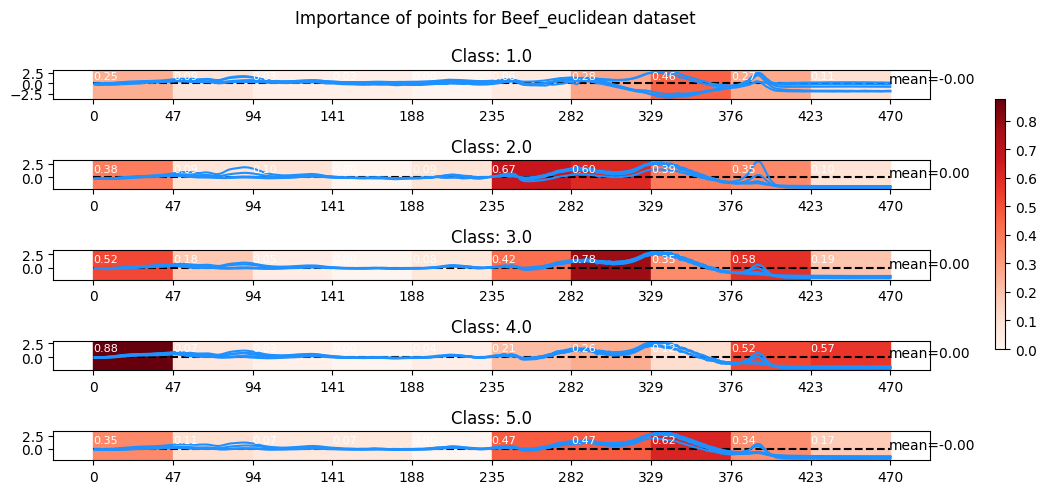

In [27]:
from fedot_ind.tools.explain.explain import PointExplainer

distance = 'euclidean'
explainer = PointExplainer(automl_model,test_data_beef[0],test_data_beef[1])
explainer.explain(n_samples=5, window=10, method=distance)
explainer.visual(threshold=0, name=dataset+'_'+distance)

Processing points: 100%|██████████| 10/10 [00:00<00:00, 501.57point/s]


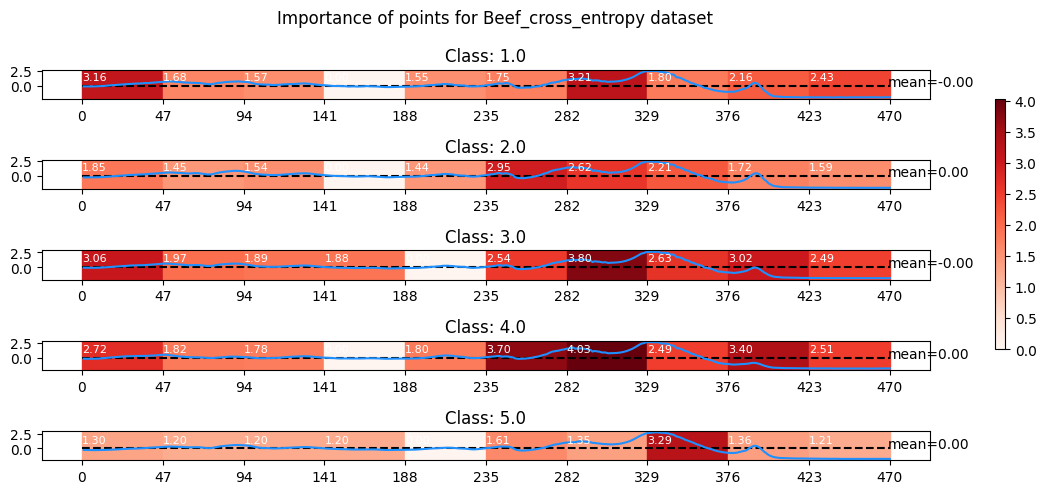

In [29]:
distance = 'cross_entropy'
explainer = PointExplainer(automl_model,test_data_beef[0],test_data_beef[1])
explainer.explain(n_samples=1, window=10, method=distance)
explainer.visual(threshold=0, name=dataset+'_'+distance)

Processing points: 100%|██████████| 10/10 [00:00<00:00, 435.93point/s]


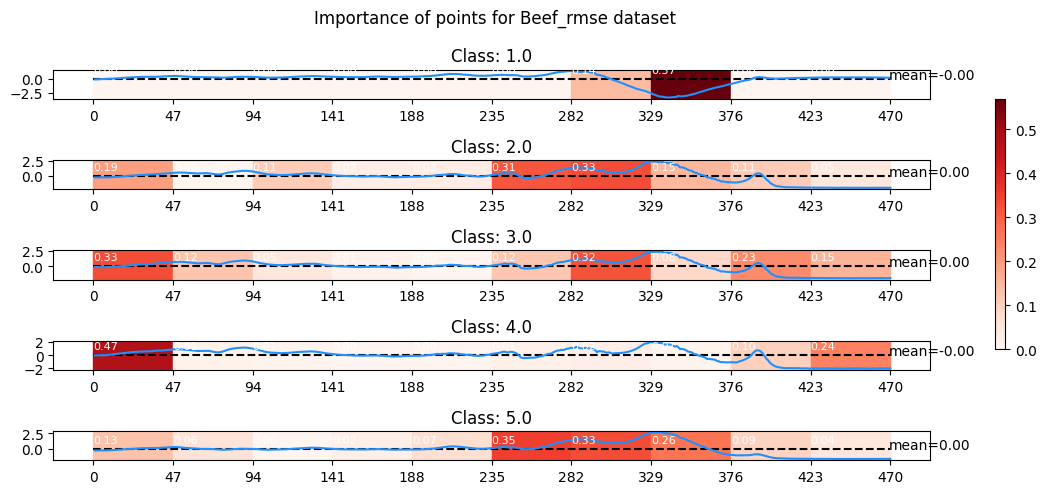

In [30]:
distance = 'rmse'
explainer = PointExplainer(automl_model,test_data_beef[0],test_data_beef[1])
explainer.explain(n_samples=1, window=10, method=distance)
explainer.visual(threshold=0, name=dataset+'_'+distance)